## Genre by lyrics.
## Idea of this small project is to identify the music genres according to the lyrics.

Steps:
1. Cleaning
2. Analaysis of length distribution
3. Language identification
4. Shortcuts processing
5. Mapping of a signer to spotify genres
6. Word count
7. Prediction

The initial data was taked from: https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics


In [1]:
import pandas as pd
import numpy as np
import re

#language detection
from langdetect import detect

from collections import Counter

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#plotting
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
%matplotlib inline  

#predictions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

from multiprocessing import Pool



import imp, os
util = imp.load_source('scikit_scripts', os.path.expanduser('/Users/kokatjuhha/Desktop/Programs/scikit_scripts/plot_confusion_matrix.py'))
from scikit_scripts import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score

from sklearn.grid_search import GridSearchCV


pd.options.display.max_colwidth = 200

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kokatjuhha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/Users/kokatjuhha/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/kokatjuhha/miniconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 1. LOAD AND CLEAN UP THE DATA

In [2]:
music = pd.read_csv('/Users/kokatjuhha/Desktop/my_project/lyrics.csv')

#### Some songs are instumental and therefore are not needed in the analysis.

In [3]:
music.describe(include=['O'])

,song,artist,genre,lyrics
count,362235,362237,362237,266557
unique,250472,18231,12,244873
top,intro,dolly-parton,Rock,INSTRUMENTAL
freq,366,755,131377,1369


In [4]:
music.groupby('genre').size()

genre
Country           17286
Electronic        16205
Folk               3241
Hip-Hop           33965
Indie              5732
Jazz              17147
Metal             28408
Not Available     29814
Other             23683
Pop               49444
R&B                5935
Rock             131377
dtype: int64

In [5]:
music = music[(music.genre != 'Other') & (music.genre != 'Not Available')]

In [6]:
music.describe(include=['O'])

,song,artist,genre,lyrics
count,308738,308740,308740,237427
unique,217235,12153,10,219241
top,intro,dolly-parton,Rock,INSTRUMENTAL
freq,341,755,131377,865


#### Include only alphabetical charachters and replace "-" and '\n' with a space to have a proper sentence ending and seperate repettions like she-she-she.

In [7]:
music.dropna(subset= ['lyrics'], inplace = True)

In [8]:
music.describe(include=['O'])

,song,artist,genre,lyrics
count,237426,237427,237427,237427
unique,169215,10104,10,219241
top,intro,dolly-parton,Rock,INSTRUMENTAL
freq,183,744,109235,865


In [9]:
def clean_up(data):
    df = data.copy()
    df.lyrics = df.lyrics.str.lower()
    def fun(line):
        line = line.replace('-', ' ')
        line = line.replace('\n', ' ')
        return re.sub("[^a-zA-Z/// ]+", '', line)
    
    df.lyrics = df.lyrics.apply(lambda x : fun(x))   
    #df.lyrics = df.lyrics.apply(lambda  x : re.sub("[^a-zA-Z0-9///' ]+", "", x))
    df.lyrics = df.lyrics.apply(lambda  x : x.strip())
    df = df[df.lyrics != ""]
    return df

In [10]:
music = clean_up(music)

#### There is several songs with an artist 'eurovisian' that are inccorectly assigned to genres. We will exclude them.

In [11]:
music = music[music.artist != 'eurovision']

In [12]:
music.describe(include=['O'])

,song,artist,genre,lyrics
count,236663,236664,236664,236664
unique,168483,10086,10,217252
top,intro,dolly-parton,Rock,instrumental
freq,183,744,108584,3117


## 2. Analaysis of length distribution
Some of the songs have very small number of words and some very big. Songs of around 132 words are the most frequent. We will exclude songs that have less than 6 words.

In [13]:
music['song_length']= [len(x.split(" ")) for x in music.lyrics]

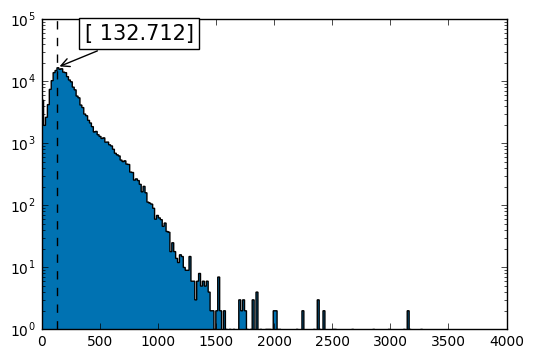

In [14]:
fig, ax = plt.subplots()
n,b, _ = ax.hist(music['song_length'], histtype='stepfilled', bins = 500)
bin_max = np.where(n == n.max())
peak = b[bin_max]
ax.axvline(peak, color='black', linestyle='dashed', linewidth=1)
plt.xlim(0,4000)
plt.gca().set_yscale("log")
ax.annotate(str(peak), (peak, 16800), xytext=(20, 20), size=15,
                    textcoords='offset points',
                    bbox={'facecolor':'white'},
                    arrowprops={'arrowstyle':'->'})


In [15]:
print("Mean of song length: %0.3f" % np.mean(music.song_length))
print("Median of song length: %0.3f" % np.median(music.song_length))

Mean of song length: 230.771
Median of song length: 193.000


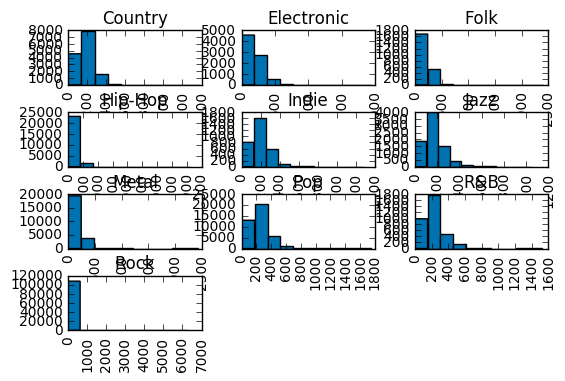

In [16]:
music.song_length.hist(by=music['genre'])
plt.gca().set_yscale("log")

#### Songs that are longer than 1500 words are hip-hop and rock songs

In [17]:
music[music.song_length>= 1500].groupby('genre').size()

genre
Electronic     1
Folk           1
Hip-Hop       38
Metal          3
Pop            2
R&B            1
Rock          23
dtype: int64

In [18]:
music[music.song_length < 3].groupby('genre').size()

genre
Country         65
Electronic     384
Folk           138
Hip-Hop         90
Indie           47
Jazz           147
Metal          841
Pop            215
R&B             11
Rock          1527
dtype: int64

#### Exclude songs that have less than 10 words. (Instrumental songs are excluded than as well)

In [19]:
music = music[music.song_length > 10]

In [20]:
music.describe(include=['O'])

,song,artist,genre,lyrics
count,232385,232386,232386,232386
unique,165196,10060,10,216353
top,intro,dolly-parton,Rock,have yourself a merry little christmas let your heart be light from now on our troubles will be out of sight have yourself a merry little christmas make the yuletide gay from now on our troubles w...
freq,136,744,106729,34


#### There are remixes and they can belog to different genres while having the samy lyrics.

In [21]:
counts = Counter(elem for elem in music.lyrics)
remixes = [ k for k in counts.keys() if counts[k] > 1 ]
len(remixes)

12670

#### There are 14754 non unique songs. The remixes will be left, however there are some songs of the same artists wuth the samy lyrics but different song name. We will exclude records with the same lyrics if they belong to the same genre. 
To speed up the process multithreading is used. Each thread gets the arguments it will workd with. At the end the results will be concatenated. _find range_ splits the data into even parts for each thread to work with. (You might want to use different count in case of more than 4 CPUs). Some remixes have the same year as the original song (but have different song names what is weird), we will leave just one copy of this song.

In [22]:
def find_range(shapes, count=1000):
    location = [[i*count,(i+1)*count] for i in range(0,shapes/count)]
    location.append([location[-1][1], shapes +1 ])
    return location

def exclude_remixes(remixes):
    excl_ind = []
    for i, rem in enumerate(remixes):
        if i%2000 == 0:
            print(i)
        
        df_rem = music[music.lyrics == rem]
        genres = df_rem.genre.unique()
        for gen in genres:
            index_remi = df_rem[df_rem.genre == gen].index.tolist()[1:]
            excl_ind = excl_ind + index_remi
    return excl_ind

In [23]:
location = find_range(len(remixes), 4000)
args = [remixes[loc[0]:loc[1]] for loc in location]
pool = Pool()
results = pool.map(exclude_remixes, args)
results = reduce(lambda x,y: x+y, results)
music.drop(results, inplace = True)
pool.close()

0
0
0
0
2000
2000
2000


In [24]:
music.describe(include=['O'])

,song,artist,genre,lyrics
count,217946,217947,217947,217947
unique,156849,10015,10,216353
top,intro,dolly-parton,Rock,have yourself a merry little christmas let your heart be light from now on our troubles will be out of sight have yourself a merry little christmas make the yuletide gay from now on our troubles w...
freq,108,706,100939,7


In [25]:
music = music[music.lyrics != 'we are not in a position to display these lyrics due to licensing restrictions sorry for the inconvinience']

In [26]:
music.groupby('genre').size()

genre
Country        13664
Electronic      6940
Folk            1970
Hip-Hop        22511
Indie           3017
Jazz            6725
Metal          22085
Pop            36950
R&B             3140
Rock          100938
dtype: int64

## 3. Language Identification
#### Only english song will be included in the analysis. Therefore, we need first to identofy the language (long process). 

In [27]:
location = find_range(music.shape[0])
args = []
for loc in location:
    arg = music.iloc[loc[0]:loc[1]]
    args.append(arg)

In [28]:
def map_language(data):
    df = data.copy()
    df['language'] = df.lyrics.apply(lambda  x : detect(x))
    return df

In [29]:
pool = Pool()
results = pool.map(map_language, args)
pool.terminate()

In [30]:
sample_lang = results[0]
for x in range(1, len(results)): 
    sample_lang = pd.concat([sample_lang, results[x]], axis=0)

In [32]:
sample_lang.to_csv('~/Desktop/my_project/mapped_songs.csv')

In [33]:
sample_lang.groupby("language").size()

language
af        91
ca        75
cs        11
cy       151
da        80
de      2678
en    202518
es      5377
et        41
fi       396
fr      1363
hr       255
hu       106
id       513
it      1188
lt        69
lv         5
nl       328
no       262
pl       114
pt       571
ro        53
sk        16
sl        31
so       174
sq        19
sv       227
sw       646
tl       280
tr       293
vi         9
dtype: int64

#### Leave only english songs with 

In [34]:
sample_en = sample_lang[sample_lang.language == 'en']
sample_en.groupby("genre").size()

genre
Country       13600
Electronic     6422
Folk           1693
Hip-Hop       20868
Indie          2890
Jazz           6297
Metal         20777
Pop           31960
R&B            3096
Rock          94915
dtype: int64

### 3.1 Shortcuts processing
#### Shortcuts such as "Im" or "I'm" are not identified as stopwords, so I will rename some of the shortcuts to their full version.

In [35]:
def rename_shortcuts(line):
    line = line.replace(" im ", " i am ")
    line = line.replace(" i'm ", " i am ")
    line = line.replace(" i'll ", " i will ")
    line = line.replace(" youre ", " you are ")
    line = line.replace("chorus", "")
    line = " ".join([item for item in str.split(line) if item not in stop_words])
    return line

In [36]:
stop_words = stopwords.words('english')
sample_en.lyrics = sample_en.lyrics.apply(lambda x: rename_shortcuts(x))
#sample_int.lyrics = sample_int.lyrics.apply(lambda x: rename_shortcuts(x))

/Users/kokatjuhha/miniconda2/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [37]:
sample_en.to_csv('~/Desktop/my_project/mapped_en.csv')

## 4. Sentiment Analysis

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [ ]:
dict_si = {'pos': [], 'neg': [], 'neu' : [], 'compound' : []}

for i, x in enumerate(sample_en.lyrics):
    si = sid.polarity_scores(x)
    for key in si:
        dict_si[key].append(si[key])
        
sample_en['pos'] = dict_si['pos']
sample_en['neg'] = dict_si['neg']
sample_en['neu'] = dict_si['neu']



In [ ]:
sample_en.sort_values(by = ['pos'], ascending=[0]).head(10)

In [ ]:
sample_en.sort_values(by = ['neg'], ascending=[0]).head(10)

## 5. Map a genre from spotify


### 5.1 Reasons for using spotify

I was suspecious about the genres in the original dataset, so I mapped the singers to genres using spotify.

In [38]:
sample_en = sample_en[['song', 'year', 'artist', 'genre', 'lyrics', 'song_length', 'language']]

In [40]:
sample_en['artist'] = sample_en['artist'].str.replace('-', '+')
sample_en['genre'] = sample_en['genre'].str.replace('-', ' ')
sample_en['genre'] = sample_en['genre'].str.lower()

The dataset shows theat 'eek a mouse' produces elektronic music, however, the genre is actally reggae.

In [43]:
sample_en[sample_en.artist == 'eek+a+mouse'].head(1)

,song,year,artist,genre,lyrics,song_length,language
240037,wa-do-dem,2013,eek+a+mouse,electronic,wa dem wa dem dem dem nuh know nuh know seh love fi mi virgin girl gung ho really love love fe see wey walk pose fancy rose match clothes gung ho fi mi virgin girl love fe see hair fulla curl anyw...,220,en


In [44]:
artists = sample_en['artist'].unique()
print(len(artists))
artists = pd.DataFrame({'artists': artists})
artists['genre'] = None

9127


### 5.2 Spotify mapping

In [45]:
import spotipy
import spotipy.util as util
token = util.prompt_for_user_token('ki', scope=None, client_id='xxxx', client_secret='xxxx', redirect_uri='http://localhost')



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?redirect_uri=http%3A%2F%2Flocalhost&response_type=code&client_id=xxxx in your browser


Enter the URL you were redirected to: http://localhost/?code=AQBI2ZmBlxzCIZ62mxka3JbVotmlpuVw1GoKf-b7cldZxToXmxT6lHAfouoDULqVx3eaYCO6-rzI2dZvc2qYRW1JL1EI1Fv5Oyydm0mJvC9oDRpMYvpwu0Omo1aKZFurFei-b4UoLIb1e5xsbPrlZHB2KOz9kfX5g203NxjllPR1zOZbWrc




In [46]:
spotify = spotipy.Spotify(auth=token)

for ind, name in enumerate(artists.artists):
    results = spotify.search(q='artist:' + name, type='artist')
    try:
        if (ind%1000==0):
            print(ind)
        genre = results["artists"]['items'][0]['genres']
    except:
        genre = 'not_known'
    artists.loc[ind].genre = genre
#artists.to_csv('~/Desktop/my_project/artists_genres.csv')

0
1000
2000
3000
4000
5000
retrying ...1secs
retrying ...1secs
retrying ...1secs
6000
7000
8000
9000


### 5.3 Comparison of genres from the original dataset and spotify.

In [48]:
artists_main = artists.copy()

In [47]:
artists['real_genre'] = None

In [49]:
def most_common(lst):
    return max(set(lst), key=lst.count)

#genre in datatset does not coincide with genre in spotify
def find_right_genres(row):
    genres = row['genre']
    artist_name = row['artists']
    init_data = sample_en[sample_en['artist'] == artist_name]
    genre_init_data = init_data.genre.iloc[0]
    if genres != 'not_known' or not genres:
        index = [i for i, x in enumerate(genres) if x.find(genre_init_data)!=-1]
        # if spotify genres contains the initial genre
        if index:
            genre_str = genre_init_data
        # if not find the most common genre in spotify
        else:       
            possible_genres = [x for i, x in enumerate(genres) if i not in index]
            if possible_genres:
                possible_genres = [x.split(" ") for x in possible_genres]
                possible_genres = [item for sublist in possible_genres for item in sublist]
                genre_str = most_common(possible_genres)
            else:
                genre_str = genre_init_data
        ret = genre_str
    else:
        ret = genre_init_data
    return ret
artists['real_genre'] = artists.apply(lambda row_art: find_right_genres(row_art), axis=1)          

Wiki says the genre of george maple is electronic, as well as our itial dataset states. 

In [50]:
print(artists[artists["artists"] == "george+maple"].real_genre)
print(sample_en[sample_en["artist"] == "george+maple"].genre)

1218    indie
Name: real_genre, dtype: object
45475    electronic
Name: genre, dtype: object


The genre of eek a mouse is really reggae.

In [53]:
print(artists[artists.artists == 'eek+a+mouse'].real_genre)
print(sample_en[sample_en.artist == 'eek+a+mouse'].genre.iloc[0])

6064    reggae
Name: real_genre, dtype: object
electronic


Create a ready data by mergining the spotify genres and initial dataset

In [147]:
ready_data = sample_en.merge(artists, left_on ='artist', right_on = 'artists')[['song', 'year', 'artist','genre_x','real_genre','genre_y', 'lyrics', 'song_length', 'language']]

Number of genres has increased but the number of songs in each genre has also decreased as we are more specific now.

In [148]:
gen_size = ready_data.groupby(['real_genre']).size().reset_index(name='size')
gen_size[gen_size['size'] > 500]
#gf[(gf['size'] > 100) & (gf['size'] < 500)]

,real_genre,size
5,alternative,733
27,blues,538
54,christian,986
66,country,14812
100,electronic,2438
104,emo,1427
121,folk,1288
139,gold,507
155,hip,768
156,hip hop,16434


Lets have a look what 'gold' genre means. Bee and bee-gees produced pop music, so switch to it.

In [149]:
print(ready_data[ready_data['real_genre']== 'gold'].groupby('artist').size())
ready_data.loc[ready_data['real_genre']== 'gold', 'real_genre'] = 'pop'

artist
bee           4
bee+gees    503
dtype: int64


I wanted to check what musucisions fell into "hip" genre to find if some of them do not belong to hip-hop. Those who do belong to hip hop I will disrerd as our hip-hop group is quite big. And only one group is changed to r&b.

In [150]:
(ready_data[ready_data['real_genre']== 'hip'].groupby('artist').size())

artist
2+brothers+on+the+4th+floor    14
2+fabiola                       6
2+unlimited                    50
28+days                        35
666                             7
ab+logic                        1
action+action                  30
adam                            3
alchemist                      54
alice+deejay                   12
amil                           15
angie+martinez                 29
anirudh+ravichander             2
apache+indian                  20
apollo                          3
arjun                           4
black+buddafly                 39
brianna+perry                   5
butterfingers                  37
c+block                        13
c+c+music+factory              12
c+side                          1
candy+hill                      5
captain+hollywood+project       5
captain+jack                   13
cb+milton                      13
charizma                        1
charli+baltimore               24
chief                           1
chubb+r

According to wikipedia eternal were a hip-hop band, although our initial datatset stated that it is metal. apologetix is a comedy christian rocj band that rewrites christian songs

In [59]:
#ready_data[ready_data['artist']== 'eternal'].head(1)
#ready_data[ready_data['artist']== 'charli+baltimore'].head(1)
#ready_data[ready_data['artist']== 'eternal'].head(1)

In [151]:
ready_data.loc[ready_data['artist']== 'black+buddafly', 'real_genre'] ='r&b'
ready_data.loc[ready_data['artist']== 'apologetix', 'real_genre'] ='rock'

There are two possible solutions now:
    1. For genres that have less than 500 songs we will use the initial genre to have more songs for the genre. But in fact the initial genre was suspecious, so it might intefere with the results.
    2. Only spotify genres with more than 500 songs will be used in the futher analysis. 500 songs might be not enough to distinguis closely related genres but lets try.

First solution

In [61]:
#for x in gen_size[gen_size['size'] < 500 ].real_genre:
#    ready_data.loc[ready_data['real_genre']== x,'real_genre'] = ready_data[ready_data['real_genre']== x]['genre_x']

Second solution

In [152]:
gen_size = ready_data.groupby(['real_genre']).size().reset_index(name='size')
chosen_genre = gen_size[(gen_size['size'] > 500) & (gen_size['real_genre'] != 'hip')]

In [153]:
ready_data = ready_data.merge(chosen_genre, how = 'inner', left_on = 'real_genre', right_on = 'real_genre')

### 5.4 Differentiate between modern christian songs and classical christian songs.

In [154]:
christian_modern = ['christian hardcore', 'christian punk', 'christian metal', 'christian rock']
ind = ready_data[ready_data['real_genre'] == "christian"].index
for i in ind:
    if set(ready_data.loc[i].genre_y) & set(christian_modern):
        ready_data.loc[i, 'real_genre'] = 'modern christian'
#def differentiate_christian(ready_data):
#

In [155]:
gen_size = ready_data.groupby(['real_genre']).size().reset_index(name='size')
gen_size

,real_genre,size
0,alternative,733
1,blues,538
2,christian,348
3,country,14812
4,electronic,2438
5,emo,1427
6,folk,1288
7,hip hop,16434
8,house,1673
9,indie,3798


## 6.Word Count for each genre

In [156]:
def create_word_count(data):
    fig = plt.figure(figsize=(20, 20))
    for i, genre in enumerate(data.real_genre.unique()):
    
        word_string = " ".join(data.lyrics[data.real_genre == genre].sample(n=348))
        wordcloud = WordCloud(background_color="white",
                          width=1200, height=1000,
                          stopwords=STOPWORDS
                         ).generate(word_string)

        plt.subplot(5,5,i+1)
        plt.imshow(wordcloud)
        plt.title(genre)
        plt.axis('off')
    plt.show()

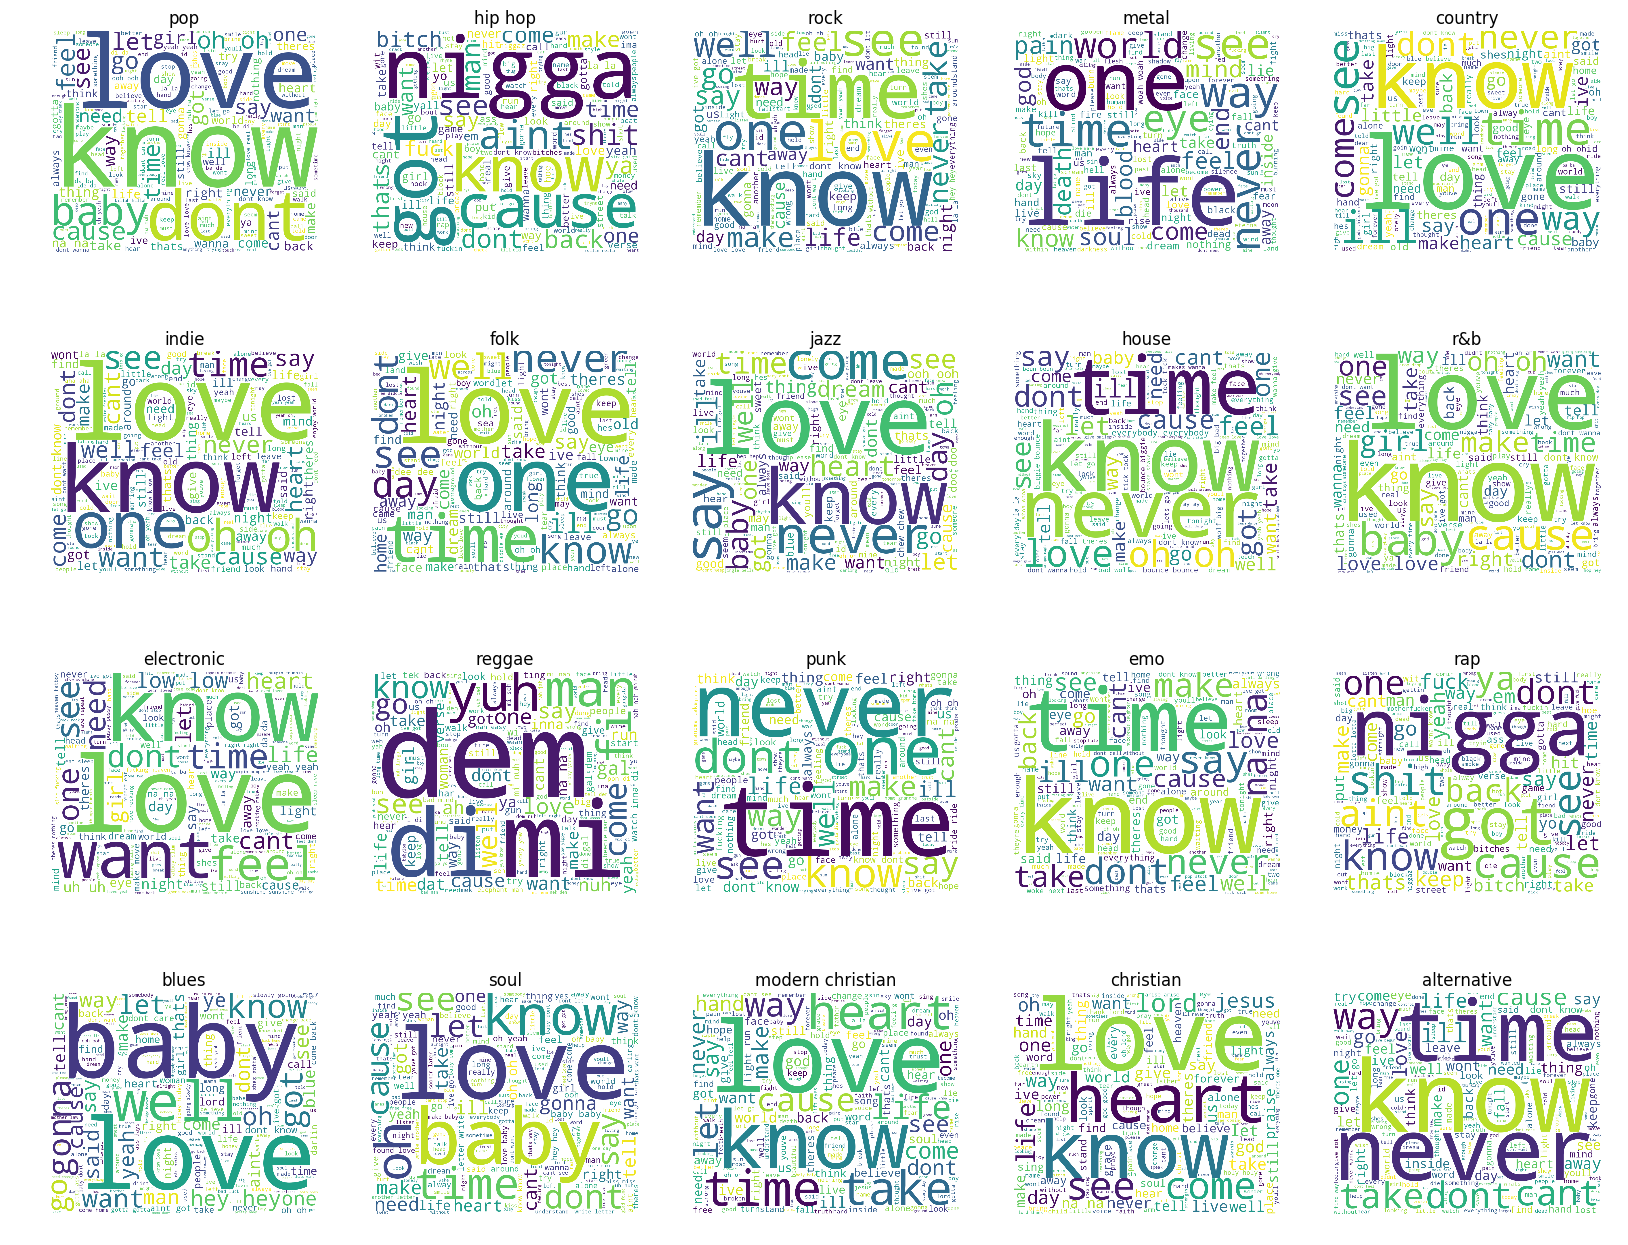

In [157]:
create_word_count(ready_data)

Interestingly that reggae has so many slang or expression words like mi, dem, yuh, nuh.

## 7. Classification

### 7.1 Neccessary functions ...
1. to create train and test sets
2. to vectorize and classify

In [158]:
def create_train_test_sets(data):
    grouped = data.groupby('real_genre')
    def specify_sample_site(x):
        size = x.shape[0]
        if size > 1500:
            size = 1500
        return size
    
    dataset = grouped.apply(lambda x: x.sample(n = specify_sample_site(x)))
    dataset.reset_index(level='real_genre', drop =True, inplace = True)

    train = dataset.groupby('real_genre').apply(lambda x: x.sample(frac = 0.8))
    train.reset_index(level = 'real_genre', drop=True, inplace = True)
    exclude = dataset.index.isin(train.index.tolist())

    test = dataset[~exclude]
    return [train, test]


def vectorize(vectorizer, data):
    train, test = data
    X_train = vectorizer.fit_transform(train.lyrics)
    Y_train = train.real_genre

    #X_valida = vectorizer.transform(validation.lyrics)
    #Y_valida = validation.genre

    X_test = vectorizer.transform(test.lyrics)
    Y_test = test.real_genre
    
    return [X_train,Y_train, X_test, Y_test]
    

def grid_search(clf, X, Y, parameters, cv):
    grid_model = GridSearchCV(estimator=clf, param_grid=parameters, cv=cv)
    grid_model.fit(X, Y)
    #grid_model.cv_results_
    print("Best Score:", grid_model.best_score_," / Best parameters:", grid_model.best_params_)
    return grid_model.best_params_

def classify(clf, data):
    X_train, Y_train, X_test, Y_test = data
    clf.fit(X_train, Y_train)
    genres = np.unique(Y_train)
    
    train_predictions = clf.predict(X_train)
    cm = confusion_matrix(Y_train, train_predictions,genres)
    #plt.figure()
    #plot_confusion_matrix(cm, classes=genres)
    accuracy = round(np.trace(cm)/float(np.sum(cm)),6)
    print("Train")
    print(accuracy)
    
    
    test_predictions = clf.predict(X_test)
    cm = confusion_matrix(Y_test, test_predictions,genres)
    plt.figure()
    plot_confusion_matrix(cm, classes=genres)
    accuracy = round(np.trace(cm)/float(np.sum(cm)),6)
    print("Test")
    print(accuracy)
    plt.show()
    return test_predictions
    
def train_test_vectorize(data):
    train_test_set = create_train_test_sets(data)
    _, test = train_test_set
    vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
    X_train, Y_train, X_test, Y_test = vectorize(vectorizer, train_test_set)
    return [test, vectorize(vectorizer, train_test_set)]

def fit_and_predict(data, clf_type = 'MultinomialNB'):
    np.random.seed(555)
    test, train_test_vec = train_test_vectorize(data)
    X_train, Y_train, _, Y_test = train_test_vec
    print(clf_type)
    if clf_type == 'MultinomialNB':
        clf = MultinomialNB()
        parameters = [{'alpha': [0.01, 0.1, 0.2, 0.5, 1]}]
        grid_search(clf, X_train, Y_train, parameters, 5)
        clf = MultinomialNB(alpha = 0.01)
        test_predictions = classify(clf, train_test_vec)
        df = pd.DataFrame({'predict': test_predictions, 'real': Y_test})
    else:
        clf = SGDClassifier(random_state=555)
        parameters = {
            'loss': ('log', 'hinge'),
            'penalty': ['l1', 'l2', 'elasticnet'],
            'alpha': [0.001, 0.0001, 0.00001, 0.000001]
        }
        grid_search(clf, X_train, Y_train, parameters, 5)
        clf = SGDClassifier(random_state=555, penalty = 'l2',alpha= 0.0001, loss= 'log')
        test_predictions = classify(clf, train_test_vec)
        df = pd.DataFrame({'predict': test_predictions, 'real': Y_test})
       
    return df, test


In [106]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

### 7.2 Classify different genres
#### 7.2.1 Very different genres
Lets take only genres that are not that similar to each other.

MultinomialNB
('Best Score:', 0.6897226173541963, ' / Best parameters:', {'alpha': 0.01})
Train
0.928698
Confusion matrix, without normalization
[[ 27   1  10  13  19   0]
 [  0 264   5   6  24   1]
 [  7  15 176  20  79   3]
 [  2  12   8 236  42   0]
 [  2  33  55  30 180   0]
 [  0   3   9   8  23  94]]


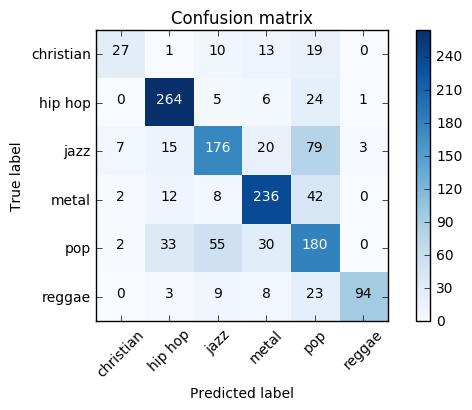

Test
0.694385


In [160]:
very_different = ['metal', 'hip hop', 'jazz', 'christian', 'pop', 'reggae']
different_data = ready_data[ready_data['real_genre'].isin(very_different)]

class_df, test = fit_and_predict(different_data)

Interestingly some christian songs were predicted to be hip-hop!
* crystal+lewis lyrics for this song is somewhat really depressive.

In [161]:
ind = class_df[(class_df.predict == 'hip hop') &(class_df.real == 'christian')].head().index
print(test.loc[ind][['artist','genre_x', 'genre_y', 'lyrics']])

               artist genre_x  \
181572  crystal+lewis     pop   

                                                                                         genre_y  \
181572  [ccm, christian alternative rock, christian christmas, christian music, gospel, worship]   

                                                                                                                                                                                                         lyrics  
181572  copyright bill baumgart michael campion tim heintz runnin time spendin every dime feeling alone night wonderin right every day work hard playin every single card butdeep inside search find open do...  


Some reaggae songs were also predicted to be hip-hop!

In [164]:
ind = class_df[(class_df.predict == 'hip hop') &(class_df.real == 'reggae')].head().index
print(test.loc[ind][['artist','genre_x', 'genre_y', 'lyrics']])

                        artist     genre_x  \
172109  bob+marley+the+wailers        rock   
172197  bob+marley+the+wailers        rock   
171803             buju+banton  electronic   

                                                              genre_y  \
172109                                         [reggae, roots reggae]   
172197                                         [reggae, roots reggae]   
171803  [dancehall, lovers rock, reggae, reggae fusion, roots reggae]   

                                                                                                                                                                                                         lyrics  
172109  check real situation nation war nation begin end well seems like total destruction solution aint use one stop aint use nobody stop give inch take yard give yard take mile ooh man twice child every...  
172197  ooh ooh old mr joe build house away top hill old mr joe knew go got right wrote bank say heres

#### 7.2.2 Similar genres

MultinomialNB
('Best Score:', 0.6051678338565564, ' / Best parameters:', {'alpha': 0.01})
Train
0.946631
Confusion matrix, without normalization
[[254  13  29   4]
 [ 39 145 113   3]
 [ 44  77 176   3]
 [ 68  10  11  46]]


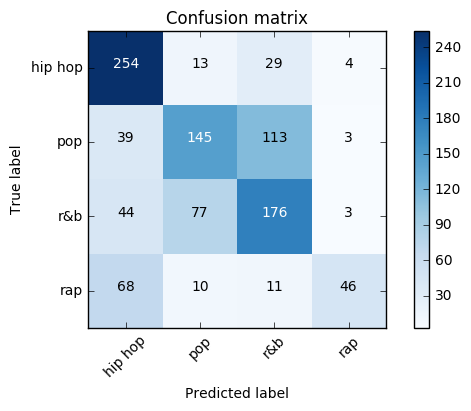

Test
0.6


In [168]:
similar = ['hip hop', 'rap', 'r&b', 'pop']
similar = ready_data[ready_data['real_genre'].isin(similar)]

class_df, test = fit_and_predict(similar)

Pop and r&b are indeed hard to distinguish and normally singers have two of those genres assigned to them.

MultinomialNB
('Best Score:', 0.6241666666666666, ' / Best parameters:', {'alpha': 0.01})
Train
0.964167
Confusion matrix, without normalization
[[163 137]
 [107 193]]


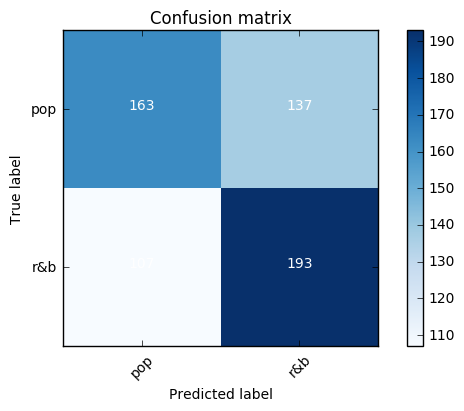

Test
0.593333


In [169]:
similar = ['r&b', 'pop']
similar = ready_data[ready_data['real_genre'].isin(similar)]

class_df, test = fit_and_predict(similar)